In [58]:
import pandas as pd
from io import StringIO
import io
import requests
import json
from io import FileIO
from json import loads, dumps
# import csv
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/Rimbik/ai-nextGen/refs/heads/main/linear_regression/sample_dataset/Food_Delivery_Times.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [59]:
### Needed to deal with Str fields in X (independent variables)
#one hot encoding using OneHotEncoder of Scikit-Learn
def one_hot_encoder(df):
    # Create a OneHotEncoder object
    import pandas as pd
    from sklearn.preprocessing import OneHotEncoder

    df = pd.DataFrame(df)

    #Extract categorical columns from the dataframe
    #Here we extract the columns with object datatype as they are the categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False)

    # Apply one-hot encoding to the categorical columns
    one_hot_encoded = encoder.fit_transform(df[categorical_columns])

    #Create a DataFrame with the one-hot encoded columns
    #We use get_feature_names_out() to get the column names for the encoded data
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    # Concatenate the one-hot encoded dataframe with the original dataframe
    df_encoded = pd.concat([df, one_hot_df], axis=1)

    # Drop the original categorical columns
    df_encoded = df_encoded.drop(categorical_columns, axis=1)
    # print(f"Encoded Employee data : \n{df_encoded}")

    return df_encoded

df_encoded = one_hot_encoder(df)


threshold = len(df_encoded) * 0.1
# Drop columns where the number of null values is greater than the threshold
# df_encoded = df_encoded.dropna(axis=1, thresh=threshold)
df_encoded = df_encoded.dropna(axis=1)

df_encoded.isnull().values.any()
df_encoded


,Order_ID,Distance_km,Preparation_Time_min,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Weather_nan,...,Traffic_Level_Medium,Traffic_Level_nan,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Time_of_Day_nan,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,522,7.93,12,43,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,738,16.42,20,84,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,741,9.52,28,59,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,661,7.44,5,37,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,412,19.03,16,68,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,107,8.50,13,54,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
996,271,16.28,8,71,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
997,861,15.62,26,81,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
998,436,14.17,8,55,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
# VIF Technique (Variance Inflation Factor - VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X):
    vif_data = pd.DataFrame()

    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data

vif_df = calculate_vif(df_encoded.drop(columns=['Order_ID','Delivery_Time_min']))

# drop features with high VIF values
# RULES : to identify high VIF
  # A) VIF > 10: Serious multicollinearity
  # B) VIF > 4 or 5: Moderate to high multicollinearity
  # C) VIF = 1: The predictor is not correlated with other variables

# Find >>
# A : features above 10 are considered to indicate serious multicollinearity
    # Price = This we will predict
    # serious multicollinearity [Year_Built, Square_Feet, Number_Bedroom]
# B : features that are greater than 4 or 5
    # [Garage_Size, Num_Bedrooms, Num_Floors, Num_Bathrooms]
# VIF = 1: The predictor is not correlated with other variables
    # Nil

# ---------------------------------------------------------------------------#
# if you get VIF = inf >> it indicates a perfect multicollinearity issue
vif_df = vif_df.sort_values(by='VIF', ascending=False)
vif_df


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
10,Traffic_Level_Medium,inf
11,Traffic_Level_nan,inf
18,Vehicle_Type_Car,inf
17,Vehicle_Type_Bike,inf
16,Time_of_Day_nan,inf
15,Time_of_Day_Night,inf
14,Time_of_Day_Morning,inf
13,Time_of_Day_Evening,inf
12,Time_of_Day_Afternoon,inf
19,Vehicle_Type_Scooter,inf


In [63]:
# Progrmatically identify colums to be dropped
def tag_columns_tobeDropped(df):
    mydf = df.copy()

    vif_df = calculate_vif(mydf)
    vif_df["candrop"] = ""
    vif_df["drop_reason"] = "-"

    vif_df = vif_df.sort_values(by='VIF', ascending=False)

    for index, row in vif_df.iterrows():
          if row["VIF"] > 10:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Serious multicollinearity"

          elif row["VIF"] > 5:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Moderate to high multicollinearity"

          elif row["VIF"] == 1:
              vif_df.at[index, "candrop"] = "Y"
              vif_df.at[index, "drop_reason"] = "Not correlated with other variables"

          # elif row["VIF"] == df.inf:
          #     vif_df.at[index, "candrop"] = "Y"
          #     vif_df.at[index, "drop_reason"] = "perfect multicollinearity issue"

          else:
              vif_df.at[index, "candrop"] = "N"
              vif_df.at[index, "drop_reason"] = "No need to drop"

    return vif_df

vif_df_indicator = tag_columns_tobeDropped(df_encoded)
vif_df_indicator



/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF,candrop,drop_reason
11,Traffic_Level_Low,inf,Y,Serious multicollinearity
12,Traffic_Level_Medium,inf,Y,Serious multicollinearity
20,Vehicle_Type_Car,inf,Y,Serious multicollinearity
19,Vehicle_Type_Bike,inf,Y,Serious multicollinearity
18,Time_of_Day_nan,inf,Y,Serious multicollinearity
17,Time_of_Day_Night,inf,Y,Serious multicollinearity
16,Time_of_Day_Morning,inf,Y,Serious multicollinearity
15,Time_of_Day_Evening,inf,Y,Serious multicollinearity
14,Time_of_Day_Afternoon,inf,Y,Serious multicollinearity
13,Traffic_Level_nan,inf,Y,Serious multicollinearity


In [64]:
high_vif_features   = vif_df_indicator[vif_df_indicator["candrop"] == "Y"]
features_canbetaken = vif_df_indicator[vif_df_indicator["candrop"] == "N"]

high_vif_features = high_vif_features["feature"].tolist()
features_canbetaken = features_canbetaken["feature"].tolist()

features_canbetaken = features_canbetaken
print(features_canbetaken)

model = df.filter(features_canbetaken, axis=1)
model = model.drop('Order_ID', axis=1)
model.head() # final model to Train


['Delivery_Time_min', 'Distance_km', 'Preparation_Time_min', 'Order_ID']


,Delivery_Time_min,Distance_km,Preparation_Time_min
0,43,7.93,12
1,84,16.42,20
2,59,9.52,28
3,37,7.44,5
4,68,19.03,16


<Axes: xlabel='Preparation_Time_min', ylabel='Delivery_Time_min'>

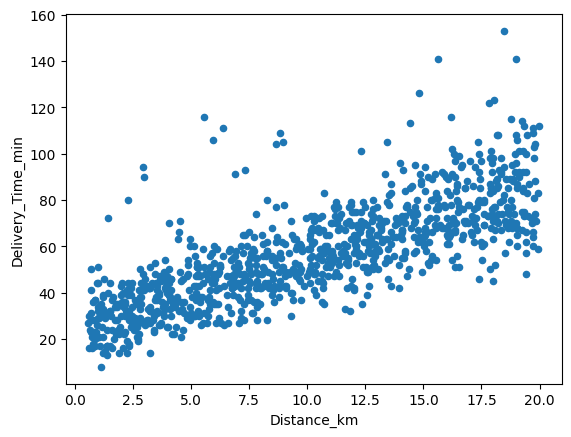

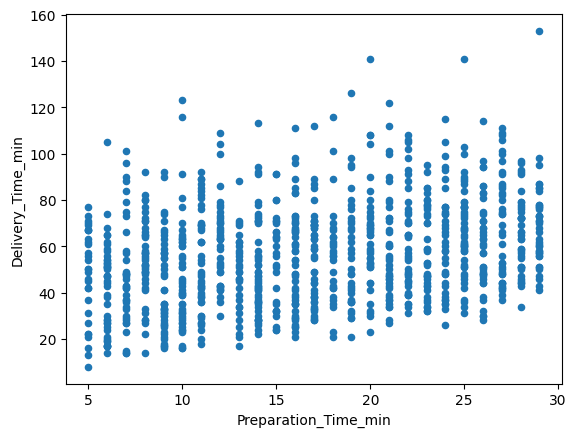

In [66]:
df_encoded.plot.scatter(x='Distance_km', y='Delivery_Time_min')
df_encoded.plot.scatter(x='Preparation_Time_min', y='Delivery_Time_min')

In [67]:

X = df_encoded.drop(columns=['Delivery_Time_min'])
y = df['Delivery_Time_min']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=11) #20% test Data
# use random_state to have the same selection in the record set everytime you run.

len(X_train), len(y_train),len(X_test),len(y_test)

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

clf.score(X_test,y_test)

0.8295044940672157